<a href="https://colab.research.google.com/github/SammyGbabs/Samuel_Babalola_RL_Summative/blob/main/Samuel_Babalola_RL_Summative_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from IPython import get_ipython
from IPython.display import display
# %%
import gymnasium as gym
import numpy as np
# Import spaces from gymnasium instead of gym
from gymnasium import spaces

class IndoorNavEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(IndoorNavEnv, self).__init__()
        self.grid_size = 20  # Increased to 20x20 grid
        self.action_space = spaces.Discrete(5)  # Up, Down, Left, Right, Wait
        # Use gymnasium.spaces.Box for observation space
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(16,), dtype=np.float32  # Added more features
        )

        # Enhanced house layout configuration
        self.rooms = {
            'living_room': (0,0,8,8),
            'kitchen': (0,12,8,20),
            'bedroom': (12,12,20,20),
            'bathroom': (12,0,20,8),
            'hallway': (8,8,12,12)
        }

        # Categorized obstacles
        self.obstacles = {
            'furniture': [(3,3), (5,15), (17,4), (9,9)],
            'appliances': [(2,18), (18,17)],
            'decorations': [(4,5), (15,15)],
            'floor_items': [(10,10), (14,14)]
        }

        # Doorway positions connecting rooms
        self.doorways = [(8,4), (4,8), (8,16), (12,16), (16,8)]

        # Initialize state variables
        self.current_room = None
        self.target_room = None
        self.agent_pos = None
        self.max_steps = 150  # Increased for larger environment
        self.current_step = 0

    def reset(self, seed=None):  # Add the seed parameter
        # Optionally, use the seed to set the random state
        if seed is not None:
            np.random.seed(seed)

        self.agent_pos = (1,1)  # Start in living room
        self.current_room = 'living_room'
        self.target_room = np.random.choice(['kitchen', 'bedroom', 'bathroom'])
        self.current_step = 0

        # Return observation and an empty info dictionary
        return self._get_obs(), {}

    def _get_obs(self):
        x, y = self.agent_pos

        # Proximity Sensors (5): Obstacle/door detection (front/back/left/right/current)
        proximity_sensors = [
            self._is_obstacle(x+1, y),  # Front
            self._is_obstacle(x-1, y),  # Back
            self._is_obstacle(x, y-1),  # Left
            self._is_obstacle(x, y+1),  # Right
            self._is_doorway(x, y),     # Current position (doorway)
        ]

        # Target Info (4): One-hot encoded target room
        target_info = self._target_room_info()  # One-hot encoded vector for target room

        # Navigation State (7): Normalized position, target distance, and remaining time
        navigation_state = [
            x / self.grid_size,          # Normalized x position
            y / self.grid_size,          # Normalized y position
            self._distance_to_target(),  # Distance to target room
            self.current_step / self.max_steps,  # Normalized time step
            0.0,  # Placeholder for additional sensor data, such as velocity or orientation
            0.0,  # Another placeholder for future sensors
            0.0,  # Placeholder for additional data
        ]


        # Combine all parts into one observation vector
        obs = np.concatenate([np.array(proximity_sensors), target_info, navigation_state], dtype=np.float32)
        # Clip observation values to be within the defined bounds
        obs = np.clip(obs, 0, 1)

        return obs

    def _target_room_info(self):
        # One-hot encoding for the target room
        target_rooms = ['kitchen', 'bedroom', 'bathroom', 'hallway']
        return np.array([1 if room == self.target_room else 0 for room in target_rooms], dtype=np.float32)

    def _is_obstacle(self, x, y):
        for category in self.obstacles.values():
            if (x,y) in category:
                return 1.0
        return 0.0

    def _is_doorway(self, x, y):
        return 1.0 if (x,y) in self.doorways else 0.0

    def _distance_to_target(self):
        tx1, ty1, tx2, ty2 = self.rooms[self.target_room]
        target_center = ((tx1+tx2)/2, (ty1+ty2)/2)
        # Ensure distance is normalized to be within [0, 1]
        distance = np.linalg.norm(np.array(self.agent_pos) - np.array(target_center)) / self.grid_size
        # Clip the distance to be within the bounds of the observation space
        distance = np.clip(distance, 0, 1)

        return distance


    def _room_identification(self):
        return np.array([
            int(self.target_room == 'kitchen'),
            int(self.target_room == 'bedroom'),
            int(self.target_room == 'bathroom'),
            int(self.target_room == 'hallway')
        ], dtype=np.float32)

    def _in_target_room(self):
        x, y = self.agent_pos
        x1, y1, x2, y2 = self.rooms[self.target_room]
        return x1 <= x <= x2 and y1 <= y <= y2

    def step(self, action):
        self.current_step += 1

        # Movement handling
        if action < 4:
            dx, dy = [(1,0), (-1,0), (0,-1), (0,1)][action]
            new_x = np.clip(self.agent_pos[0]+dx, 0,19)
            new_y = np.clip(self.agent_pos[1]+dy, 0,19)

            if not self._is_obstacle(new_x, new_y):
                self.agent_pos = (new_x, new_y)

        # Reward calculation
        reward = -0.1  # Base time penalty
        done = False
        truncated = False # Add truncated
        collision = False

        # Collision detection
        if self._is_obstacle(*self.agent_pos):
            reward = -5
            collision = True
            done = True

        # Target reached
        elif self._in_target_room():
            time_bonus = (self.max_steps - self.current_step) * 0.2
            reward = 15 + time_bonus
            done = True

        # Step limit termination
        elif self.current_step >= self.max_steps:
            reward -= 3
            done = True
            truncated = True # Set truncated to True when exceeding step limit

        # Doorway bonus
        if not done and self._is_doorway(*self.agent_pos):
            reward += 1.0  # Increased doorway incentive

        return self._get_obs(), reward, done, truncated, { # Return truncated
            'collision': collision,
            'timeout': self.current_step >= self.max_steps,
            'current_room': self.current_room
        }

    def get_obstacle_types(self):
        """Return obstacle category at given position"""
        x, y = self.agent_pos
        for cat, positions in self.obstacles.items():
            if (x,y) in positions:
                return cat
        return None

In [2]:
!pip install stable-baselines3
!pip install shimmy>=2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor
# from Environment.custom_env import IndoorNavEnv
from stable_baselines3.common.env_checker import check_env


# Configuration
SEED = 42
LOG_DIR = "./ppo_logs/"
MODEL_DIR = "./ppo_models/"
TENSORBOARD_LOG = "./ppo_tensorboard/"


# Create environment
# The error was caused because the action space was being interpreted as the observation space.
# To fix this, ensure you are using the correct policy type that corresponds to your action space.
# Since your action space is `Discrete(5)`, you should use a policy that handles discrete actions, such as 'MlpPolicy'.
env = IndoorNavEnv() # Initialize a single environment
# Check the environment
check_env(env, warn=True)
# Wrap the environment with the appropriate wrappers
env = Monitor(env) # Wrap the environment for monitoring if needed
env = DummyVecEnv([lambda: env]) # Wrap to make it compatible with Stable-Baselines3
# You can also wrap with VecCheckNan if you have NaN values in your observations
env = VecCheckNan(env, raise_exception=True) # Detects and stops on NaN observations

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

# Hyperparameters optimized for navigation tasks
params = {
    'learning_rate': 2e-4,
    'n_steps': 2048,
    'batch_size': 256,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    'clip_range_vf': None,
    'ent_coef': 0.02,
    'target_kl': 0.03,
    'policy_kwargs': dict(
        net_arch=dict(pi=[256, 256], vf=[256, 256]), # Changed to dictionary
        activation_fn=nn.ReLU,
        ortho_init=True
    )
}

# Initialize model
# Use 'MlpPolicy' which is suitable for discrete action spaces.
# The original code has an issue with how it's initialized. Removing the action space from supported_action_spaces to allow it to automatically infer it.
model = PPO(
    "MlpPolicy",  # Changed back to MlpPolicy
    env,
    verbose=1,
    tensorboard_log=TENSORBOARD_LOG,
    **params,
    # Removing 'supported_action_spaces' as it's no longer a valid argument for PPO
)

# Callbacks
stop_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=10, min_evals=5)
eval_callback = EvalCallback(
    env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=20000,
    callback_after_eval=stop_callback
)

# Training
total_timesteps = 500000
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    tb_log_name="ppo_run",
    reset_num_timesteps=True
)

# Save final model
model.save(os.path.join(MODEL_DIR, "ppo_final_model"))


Action Space: Discrete(5)
Observation Space: Box(0.0, 1.0, (16,), float32)
Using cpu device
Logging to ./ppo_tensorboard/ppo_run_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 144      |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    fps             | 942      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | -8.37       |
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013961805 |
|    clip_fraction        | 0.0586      |
|    clip_range          


PPO Evaluation Results:
Avg Reward: 41.0
Avg Steps per Episode: 14.8


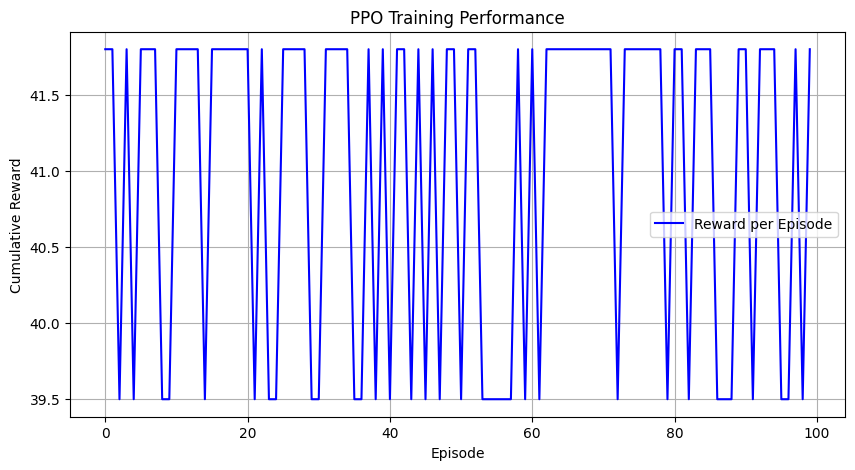

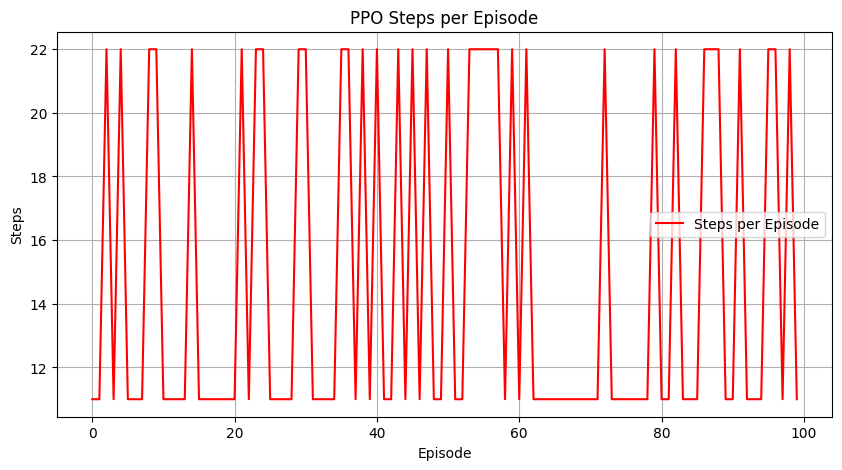

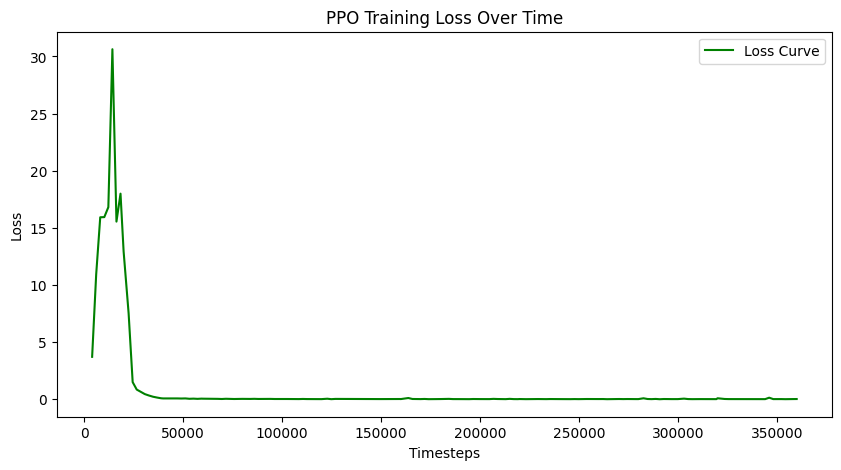

In [34]:
# Evaluation function (No success/collision rate)
def evaluate_ppo_model(model_path, num_episodes=100):
    model = PPO.load(model_path)
    # Create a new environment for evaluation and wrap it
    eval_env = IndoorNavEnv()
    eval_env = Monitor(eval_env)  # If you need to monitor the evaluation environment
    eval_env = DummyVecEnv([lambda: eval_env])

    rewards_per_episode = []
    steps_per_episode = []

    for _ in range(num_episodes):
        obs = eval_env.reset() # Get initial observation using VecEnv API
        done = False
        ep_reward = 0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True) # Assuming you want deterministic actions
            obs, reward, done, _ = eval_env.step(action) # Use VecEnv API for step
            ep_reward += reward[0] # Access reward from the list
            steps += 1

        rewards_per_episode.append(ep_reward)
        steps_per_episode.append(steps)

    avg_reward = np.mean(rewards_per_episode)
    avg_steps = np.mean(steps_per_episode)

    print("\nPPO Evaluation Results:")
    print(f"Avg Reward: {avg_reward:.1f}")
    print(f"Avg Steps per Episode: {avg_steps:.1f}")

    return rewards_per_episode, steps_per_episode # Return steps_per_episode


# Evaluate best model
rewards, steps_per_episode = evaluate_ppo_model(os.path.join(MODEL_DIR, "best_model"))


# Plot Reward Trends
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Reward per Episode", color='b')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("PPO Training Performance")
plt.legend()
plt.grid()
plt.show()

# Plot Steps per Episode
plt.figure(figsize=(10, 5))
plt.plot(steps_per_episode, label="Steps per Episode", color='r')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("PPO Steps per Episode")
plt.legend()
plt.grid()
plt.show()


# Plot loss curves from TensorBoard
def plot_loss_curve(log_dir=TENSORBOARD_LOG):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    # Update this part to search for event files recursively
    event_files = []
    for root, _, files in os.walk(log_dir):  # Walk through subdirectories
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))

    if not event_files:
        print("No TensorBoard event files found in the specified directory.")
        return

    # Choose the latest event file (you might need to adjust this logic)
    latest_event_file = max(event_files, key=os.path.getmtime)

    event_acc = EventAccumulator(latest_event_file)  # Use the latest file
    event_acc.Reload()
    losses = event_acc.Scalars("train/loss")  # Check if "loss" is the correct tag

    steps = [x.step for x in losses]
    values = [x.value for x in losses]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label="Loss Curve", color='g')
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("PPO Training Loss Over Time")
    plt.legend()
    plt.show()

plot_loss_curve()

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor
# from Environment.custom_env import IndoorNavEnv
from stable_baselines3.common.env_checker import check_env


# Configuration
SEED = 42
LOG_DIR = "./ppo_logs/"
MODEL_DIR = "./ppo_models/"
TENSORBOARD_LOG = "./ppo_tensorboard/"


# Create environment
# The error was caused because the action space was being interpreted as the observation space.
# To fix this, ensure you are using the correct policy type that corresponds to your action space.
# Since your action space is `Discrete(5)`, you should use a policy that handles discrete actions, such as 'MlpPolicy'.
env = IndoorNavEnv() # Initialize a single environment
# Check the environment
check_env(env, warn=True)
# Wrap the environment with the appropriate wrappers
env = Monitor(env) # Wrap the environment for monitoring if needed
env = DummyVecEnv([lambda: env]) # Wrap to make it compatible with Stable-Baselines3
# You can also wrap with VecCheckNan if you have NaN values in your observations
env = VecCheckNan(env, raise_exception=True) # Detects and stops on NaN observations

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

# Hyperparameters optimized for navigation tasks
params = {
    'learning_rate': 5e-4,
    'n_steps': 4096,
    'batch_size': 512,
    'n_epochs': 5,
    'gamma': 0.97,
    'gae_lambda': 0.95,
    'clip_range': 0.3,
    'ent_coef': 0.02,
    'policy_kwargs': dict(
        net_arch=dict(pi=[128, 128], vf=[512, 512, 256]), # Changed to dictionary
        activation_fn=nn.ReLU,
        ortho_init=False
    )
}

# Initialize model
# Use 'MlpPolicy' which is suitable for discrete action spaces.
# The original code has an issue with how it's initialized. Removing the action space from supported_action_spaces to allow it to automatically infer it.
model = PPO(
    "MlpPolicy",  # Changed back to MlpPolicy
    env,
    verbose=1,
    tensorboard_log=TENSORBOARD_LOG,
    **params,
    # Removing 'supported_action_spaces' as it's no longer a valid argument for PPO
)

# Callbacks
stop_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=10, min_evals=5)
eval_callback = EvalCallback(
    env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=20000,
    callback_after_eval=stop_callback
)

# Training
total_timesteps = 500000
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    tb_log_name="ppo_run",
    reset_num_timesteps=True
)

# Save final model
model.save(os.path.join(MODEL_DIR, "ppo_final_model"))


Action Space: Discrete(5)
Observation Space: Box(0.0, 1.0, (16,), float32)
Using cpu device
Logging to ./ppo_tensorboard/ppo_run_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 146      |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    fps             | 692      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | -8.46       |
| time/                   |             |
|    fps                  | 590         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014686938 |
|    clip_fraction        | 0.0165      |
|    clip_range          


PPO Evaluation Results:
Avg Reward: 40.9
Avg Steps per Episode: 13.9


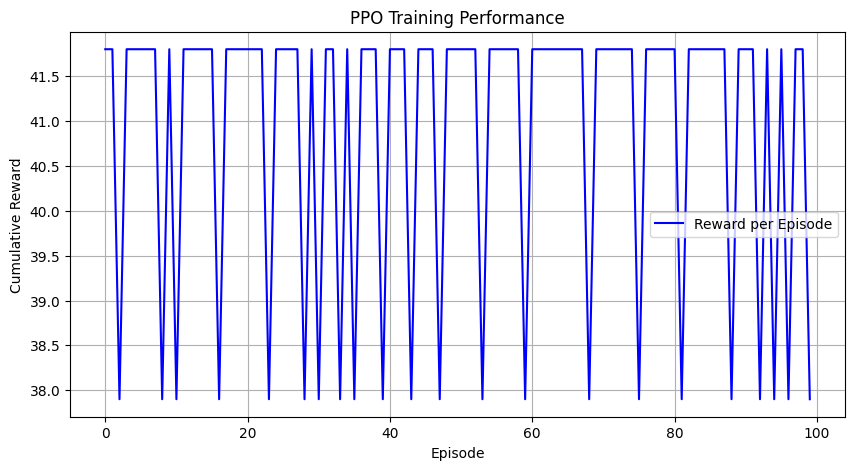

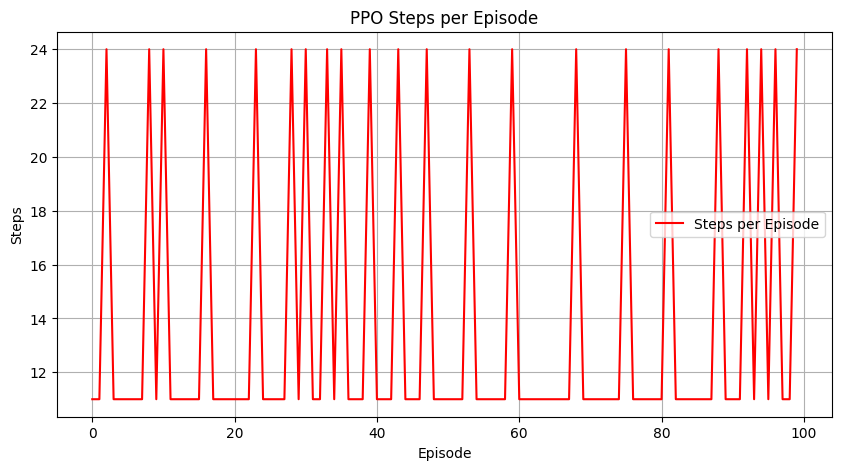

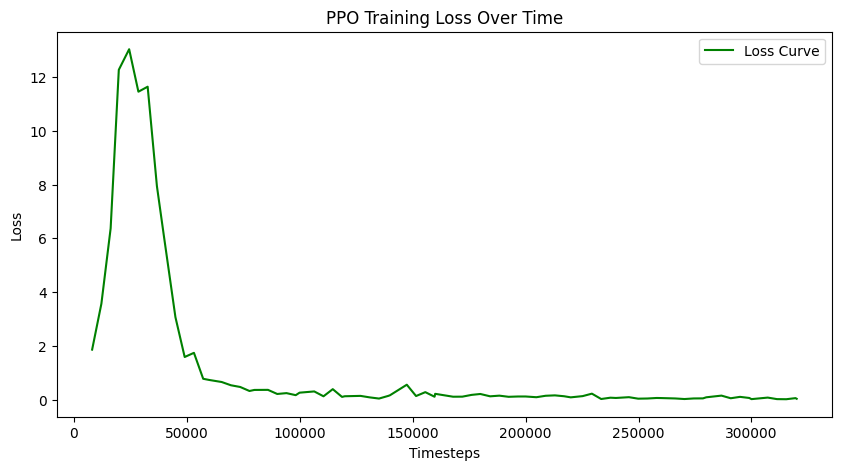

In [38]:
# Evaluation function (No success/collision rate)
def evaluate_ppo_model(model_path, num_episodes=100):
    model = PPO.load(model_path)
    # Create a new environment for evaluation and wrap it
    eval_env = IndoorNavEnv()
    eval_env = Monitor(eval_env)  # If you need to monitor the evaluation environment
    eval_env = DummyVecEnv([lambda: eval_env])

    rewards_per_episode = []
    steps_per_episode = []

    for _ in range(num_episodes):
        obs = eval_env.reset() # Get initial observation using VecEnv API
        done = False
        ep_reward = 0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True) # Assuming you want deterministic actions
            obs, reward, done, _ = eval_env.step(action) # Use VecEnv API for step
            ep_reward += reward[0] # Access reward from the list
            steps += 1

        rewards_per_episode.append(ep_reward)
        steps_per_episode.append(steps)

    avg_reward = np.mean(rewards_per_episode)
    avg_steps = np.mean(steps_per_episode)

    print("\nPPO Evaluation Results:")
    print(f"Avg Reward: {avg_reward:.1f}")
    print(f"Avg Steps per Episode: {avg_steps:.1f}")

    return rewards_per_episode, steps_per_episode # Return steps_per_episode


# Evaluate best model
rewards, steps_per_episode = evaluate_ppo_model(os.path.join(MODEL_DIR, "best_model"))


# Plot Reward Trends
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Reward per Episode", color='b')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("PPO Training Performance")
plt.legend()
plt.grid()
plt.show()

# Plot Steps per Episode
plt.figure(figsize=(10, 5))
plt.plot(steps_per_episode, label="Steps per Episode", color='r')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("PPO Steps per Episode")
plt.legend()
plt.grid()
plt.show()


# Plot loss curves from TensorBoard
def plot_loss_curve(log_dir=TENSORBOARD_LOG):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    # Update this part to search for event files recursively
    event_files = []
    for root, _, files in os.walk(log_dir):  # Walk through subdirectories
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))

    if not event_files:
        print("No TensorBoard event files found in the specified directory.")
        return

    # Choose the latest event file (you might need to adjust this logic)
    latest_event_file = max(event_files, key=os.path.getmtime)

    event_acc = EventAccumulator(latest_event_file)  # Use the latest file
    event_acc.Reload()
    losses = event_acc.Scalars("train/loss")  # Check if "loss" is the correct tag

    steps = [x.step for x in losses]
    values = [x.value for x in losses]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label="Loss Curve", color='g')
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("PPO Training Loss Over Time")
    plt.legend()
    plt.show()

plot_loss_curve()

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.monitor import Monitor
# from Environment.custom_env import IndoorNavEnv
from stable_baselines3.common.env_checker import check_env


# Configuration
SEED = 42
LOG_DIR = "./ppo_logs/"
MODEL_DIR = "./ppo_models/"
TENSORBOARD_LOG = "./ppo_tensorboard/"


# Create environment
# The error was caused because the action space was being interpreted as the observation space.
# To fix this, ensure you are using the correct policy type that corresponds to your action space.
# Since your action space is `Discrete(5)`, you should use a policy that handles discrete actions, such as 'MlpPolicy'.
env = IndoorNavEnv() # Initialize a single environment
# Check the environment
check_env(env, warn=True)
# Wrap the environment with the appropriate wrappers
env = Monitor(env) # Wrap the environment for monitoring if needed
env = DummyVecEnv([lambda: env]) # Wrap to make it compatible with Stable-Baselines3
# You can also wrap with VecCheckNan if you have NaN values in your observations
env = VecCheckNan(env, raise_exception=True) # Detects and stops on NaN observations

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

# Hyperparameters optimized for navigation tasks
params = {
    'learning_rate': 3e-4,
    'n_steps': 1024,
    'batch_size': 256,
    'n_epochs': 7,
    'gamma': 0.995,
    'gae_lambda': 0.92,
    'clip_range': 0.2,
    'ent_coef': 0.01,
    'policy_kwargs': dict(
        net_arch=dict(pi=[512, 256, 128], vf=[256, 128]), # Changed to dictionary
        activation_fn=nn.LeakyReLU,
        ortho_init=True
    )
}

# Initialize model
# Use 'MlpPolicy' which is suitable for discrete action spaces.
# The original code has an issue with how it's initialized. Removing the action space from supported_action_spaces to allow it to automatically infer it.
model = PPO(
    "MlpPolicy",  # Changed back to MlpPolicy
    env,
    verbose=1,
    tensorboard_log=TENSORBOARD_LOG,
    **params,
    # Removing 'supported_action_spaces' as it's no longer a valid argument for PPO
)

# Callbacks
stop_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=10, min_evals=5)
eval_callback = EvalCallback(
    env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=20000,
    callback_after_eval=stop_callback
)

# Training
total_timesteps = 500000
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    tb_log_name="ppo_run",
    reset_num_timesteps=True
)

# Save final model
model.save(os.path.join(MODEL_DIR, "ppo_final_model"))


Streaming output truncated to the last 5000 lines.
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0806      |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0166       |
|    n_updates            | 553          |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 0.0585       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 14.1         |
|    ep_rew_mean          | 41.2         |
| time/                   |              |
|    fps                  | 556          |
|    iterations           | 81           |
|    time_elapsed         | 149          |
|    total_timesteps      | 82944        |
| train/                  |              |
|    approx_kl            | 0.0009138262 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|  


PPO Evaluation Results:
Avg Reward: 41.1
Avg Steps per Episode: 14.3


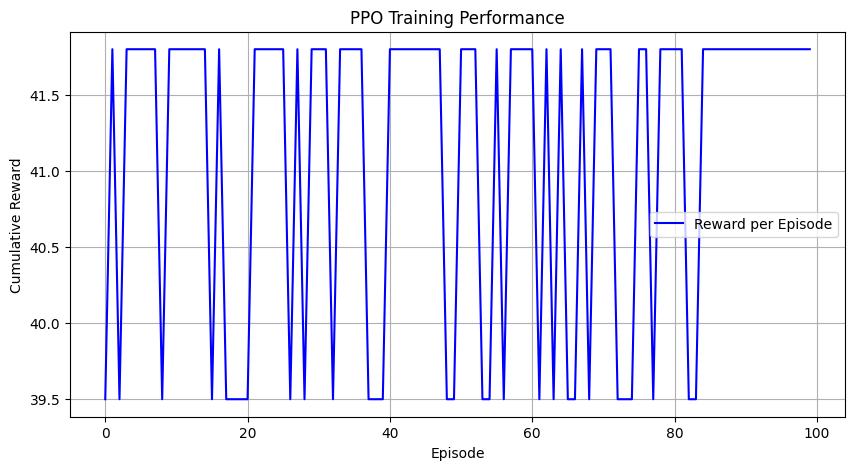

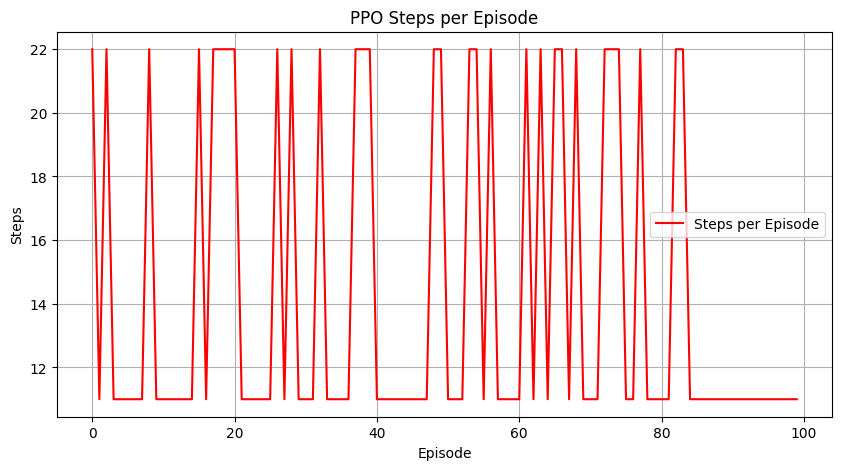

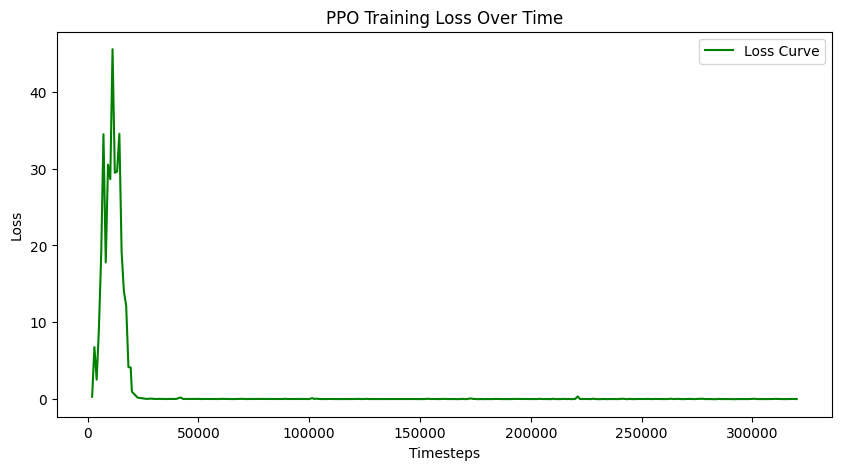

In [40]:
# Evaluation function (No success/collision rate)
def evaluate_ppo_model(model_path, num_episodes=100):
    model = PPO.load(model_path)
    # Create a new environment for evaluation and wrap it
    eval_env = IndoorNavEnv()
    eval_env = Monitor(eval_env)  # If you need to monitor the evaluation environment
    eval_env = DummyVecEnv([lambda: eval_env])

    rewards_per_episode = []
    steps_per_episode = []

    for _ in range(num_episodes):
        obs = eval_env.reset() # Get initial observation using VecEnv API
        done = False
        ep_reward = 0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True) # Assuming you want deterministic actions
            obs, reward, done, _ = eval_env.step(action) # Use VecEnv API for step
            ep_reward += reward[0] # Access reward from the list
            steps += 1

        rewards_per_episode.append(ep_reward)
        steps_per_episode.append(steps)

    avg_reward = np.mean(rewards_per_episode)
    avg_steps = np.mean(steps_per_episode)

    print("\nPPO Evaluation Results:")
    print(f"Avg Reward: {avg_reward:.1f}")
    print(f"Avg Steps per Episode: {avg_steps:.1f}")

    return rewards_per_episode, steps_per_episode # Return steps_per_episode


# Evaluate best model
rewards, steps_per_episode = evaluate_ppo_model(os.path.join(MODEL_DIR, "best_model"))


# Plot Reward Trends
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Reward per Episode", color='b')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("PPO Training Performance")
plt.legend()
plt.grid()
plt.show()

# Plot Steps per Episode
plt.figure(figsize=(10, 5))
plt.plot(steps_per_episode, label="Steps per Episode", color='r')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("PPO Steps per Episode")
plt.legend()
plt.grid()
plt.show()


# Plot loss curves from TensorBoard
def plot_loss_curve(log_dir=TENSORBOARD_LOG):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    # Update this part to search for event files recursively
    event_files = []
    for root, _, files in os.walk(log_dir):  # Walk through subdirectories
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))

    if not event_files:
        print("No TensorBoard event files found in the specified directory.")
        return

    # Choose the latest event file (you might need to adjust this logic)
    latest_event_file = max(event_files, key=os.path.getmtime)

    event_acc = EventAccumulator(latest_event_file)  # Use the latest file
    event_acc.Reload()
    losses = event_acc.Scalars("train/loss")  # Check if "loss" is the correct tag

    steps = [x.step for x in losses]
    values = [x.value for x in losses]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label="Loss Curve", color='g')
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("PPO Training Loss Over Time")
    plt.legend()
    plt.show()

plot_loss_curve()